# Awards




In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [4]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/francesco/kDrive/python_notebooks/astronomers/notebooks_jupyter/wikidata_exploration/../network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the 

...  [compléter]


In [5]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [6]:
query = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
      ?award (MIN(?aLabel) AS ?awardLabel)         
   (COUNT(*) as ?n)
   (GROUP_CONCAT(DISTINCT ?organisationLabel; separator=" | ") AS ?organisations) 
   (GROUP_CONCAT(DISTINCT ?parentTermLabel; separator=" | ") AS ?domains) 
   (GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 
   (GROUP_CONCAT(DISTINCT ?pseudoClassLabel; separator=" | ") AS ?pseudoClasses) 
     
WHERE {
      GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
         {
            ?person wdt:P166 ?award;
                     rdfs:label ?pLabel;
                     wdt:P569 ?birthYear.
            ?award rdf:type wd:Q618779;
                  rdfs:label ?aLabel.
            # has country      
            OPTIONAL {?award wdt:P17 ?country.
                ?country rdfs:label ?countryLabel    
             }
            #  instance of
            OPTIONAL {?award wdt:P31 ?pseudoClass.
                ?pseudoClass rdfs:label ?pseudoClassLabel    
             }
            # conferred by
            OPTIONAL {?award wdt:P1027 ?organisation.
                ?organisation rdfs:label ?organisationLabel    
             }  
            # subclass of
            OPTIONAL 
            {?award wdt:P279 ?parentTerm.
                ?parentTerm rdfs:label ?parentTermLabel    
             }   

         }
   }
GROUP BY ?person ?award 
ORDER BY DESC(?domains)
"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


35122
[['http://www.wikidata.org/entity/Q1819421',
  'Leonid Keldysh',
  '1931',
  'http://www.wikidata.org/entity/Q1400970',
  'Feenberg Medal',
  '1',
  '',
  'science award',
  '',
  ''],
 ['http://www.wikidata.org/entity/Q1699823',
  'John Dirk Walecka',
  '1932',
  'http://www.wikidata.org/entity/Q1400970',
  'Feenberg Medal',
  '1',
  '',
  'science award',
  '',
  ''],
 ['http://www.wikidata.org/entity/Q111270596',
  'László Csaba',
  '1935',
  'http://www.wikidata.org/entity/Q1301832',
  'Széchenyi Prize',
  '1',
  '',
  'science award',
  'Hungary',
  'science award']]


## Inspect the data


In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.head(1)



,0,1,2,3,4,5,6,7,8,9
0,http://www.wikidata.org/entity/Q20507722,Q20507722,1949,http://www.wikidata.org/entity/Q121594,professor,6,,university teacher | research fellow,,title of authority | style | academic rank


In [9]:

df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'uriAw', 'labelAw',
                'number', 
                'organisations', 'domains', 'countries', 'pseudoClasses']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  35122


,uriPer,labelPer,birthYear,uriAw,labelAw,number,organisations,domains,countries,pseudoClasses
10,http://www.wikidata.org/entity/Q1291839,Edward C. Stone,1936,http://www.wikidata.org/entity/Q209896,honorary degree,2,,title of honor | academic degree,,
11,http://www.wikidata.org/entity/Q5479986,Francis Allotey,1932,http://www.wikidata.org/entity/Q209896,honorary degree,2,,title of honor | academic degree,,
12,http://www.wikidata.org/entity/Q4258994,Aleksandr Leontyev,1927,http://www.wikidata.org/entity/Q209896,honorary degree,2,,title of honor | academic degree,,


### Distribution of awards in relation to 'generations'

In [10]:
### We adapt the periods manually
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [11]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [12]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,uriPer,labelPer,birthYear,uriAw,labelAw,number,organisations,domains,countries,pseudoClasses,periods
0,http://www.wikidata.org/entity/Q20507722,Q20507722,1949,http://www.wikidata.org/entity/Q121594,professor,6,,university teacher | research fellow,,title of authority | style | academic rank,1941-1960
1,http://www.wikidata.org/entity/Q364292,Albert Caquot,1881,http://www.wikidata.org/entity/Q11415586,honorary fellow,2,,university teacher,,honorary title | position,1851-1900
2,http://www.wikidata.org/entity/Q86970,Ferenc Krausz,1962,http://www.wikidata.org/entity/Q987080,honorary citizenship,3,,title of honor | award | Award,,title of honor,1961-1980


In [13]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1751-1800      679
1801-1850     1358
1851-1900     4247
1901-1920     6442
1921-1940    10944
1941-1960     8622
1961-1980     2449
1981-2000      381
dtype: int64


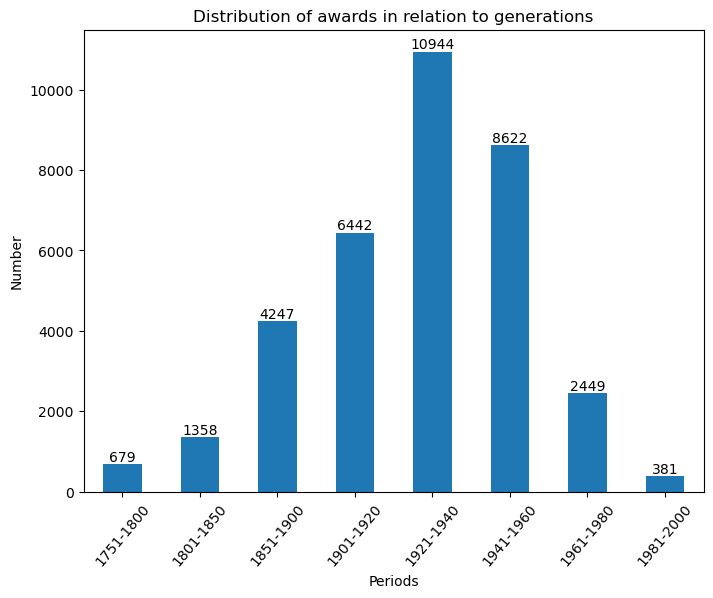

In [14]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of awards in relation to generations')
plt.show()

#### Save dataframe to CSV

In [15]:
file_add = 'data/persons_awards.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

In [16]:
### load from CSV

file_add = 'data/persons_awards.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

35122


,uriPer,labelPer,birthYear,uriAw,labelAw,number,organisations,domains,countries,pseudoClasses,periods
0,http://www.wikidata.org/entity/Q20507722,Q20507722,1949,http://www.wikidata.org/entity/Q121594,professor,6,NaN,university teacher | research fellow,NaN,title of authority | style | academic rank,1941-1960
1,http://www.wikidata.org/entity/Q364292,Albert Caquot,1881,http://www.wikidata.org/entity/Q11415586,honorary fellow,2,NaN,university teacher,NaN,honorary title | position,1851-1900


## Types of domains

Property **wdt:P279 subclass of**

In [17]:
df_p.sort_values(by='countries', ascending=False).head()

,uriPer,labelPer,birthYear,uriAw,labelAw,number,organisations,domains,countries,pseudoClasses,periods
17707,http://www.wikidata.org/entity/Q92931,Charles H. Bennett,1943,http://www.wikidata.org/entity/Q977835,Claude E. Shannon Award,2,Institute of Electrical and Electronics Engineers,NaN,internationality | United States,science award,1941-1960
20797,http://www.wikidata.org/entity/Q522090,Raimond Castaing,1921,http://www.wikidata.org/entity/Q2607382,Roebling Medal,1,Mineralogical Society of America,NaN,internationality,science award,1921-1940
21108,http://www.wikidata.org/entity/Q111028460,John B. Irwin,1909,http://www.wikidata.org/entity/Q6565314,Fulbright Prize,1,Fulbright Scholarship,NaN,internationality,NaN,1901-1920
19089,http://www.wikidata.org/entity/Q1452863,Frederick Eugene Wright,1877,http://www.wikidata.org/entity/Q2607382,Roebling Medal,1,Mineralogical Society of America,NaN,internationality,science award,1851-1900
16766,http://www.wikidata.org/entity/Q8556,Edsger W. Dijkstra,1930,http://www.wikidata.org/entity/Q1225254,Dijkstra Prize,2,Association for Computing Machinery | European...,NaN,internationality,science award,1921-1940


### Award categories

In [18]:
df_p['pseudoClasses'] = df_p['pseudoClasses'].astype(str)

In [19]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['pseudoClasses'] = df_p['pseudoClasses'].apply(lambda x : '|'.join(sorted([e.strip().lower() for e in x.split('|')])))


ll = df_p.pseudoClasses.to_list()
print(len(ll))
pprint.pprint(ll[:3])


35122
['academic rank|style|title of authority',
 'honorary title|position',
 'title of honor']


In [20]:
pprint.pprint(df_p.groupby(['labelAw','pseudoClasses'])\
              .size().sort_values(ascending=False).iloc[:20])

labelAw                                                            pseudoClasses                                     
Fellow of the American Physical Society                            fellowship award                                      1454
Guggenheim Fellowship                                              annual event|scholarship                               833
Fellow of the Royal Society                                        nan                                                    778
Order of the Red Banner of Labour                                  civil decoration|order|socialist order of merit        575
USSR State Prize                                                   official honorary titles of the soviet union|prize     406
Order of the Badge of Honour                                       civil decoration|order                                 392
Fellow of the American Association for the Advancement of Science  fellowship award                                       376


In [21]:
file_addr = 'files/award_pseudoClasses_group.csv'
df_p.groupby('pseudoClasses').size().sort_values(ascending=False).to_csv(file_addr)

### Award domains

In [22]:
df_p['domains'] = df_p['domains'].astype(str)

In [23]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['domains'] = df_p['domains'].apply(lambda x : '|'.join(sorted([e.strip().lower() for e in x.split('|')])))


ll = df_p.domains.to_list()
print(len(ll))
pprint.pprint(ll[:3])


35122
['research fellow|university teacher',
 'university teacher',
 'award|award|title of honor']


In [24]:
pprint.pprint(df_p.groupby(['labelAw','domains'])\
              .size().sort_values(ascending=False).iloc[:20])

labelAw                                                            domains                                   
Fellow of the American Physical Society                            nan                                           1454
Guggenheim Fellowship                                              academic award                                 833
Fellow of the Royal Society                                        award|award                                    778
Order of the Red Banner of Labour                                  nan                                            576
USSR State Prize                                                   nan                                            406
Order of the Badge of Honour                                       nan                                            395
Fellow of the American Association for the Advancement of Science  nan                                            376
Order of Lenin                                                  

In [25]:
file_addr = 'files/award_domains_group.csv'
df_p.groupby('domains').size().sort_values(ascending=False).to_csv(file_addr)

### Domain and type grouped

In [26]:
pprint.pprint(df_p.groupby(['labelAw','pseudoClasses', 'domains'])\
              .size().sort_values(ascending=False).iloc[:20])

labelAw                                                            pseudoClasses                                       domains                                   
Fellow of the American Physical Society                            fellowship award                                    nan                                           1454
Guggenheim Fellowship                                              annual event|scholarship                            academic award                                 833
Fellow of the Royal Society                                        nan                                                 award|award                                    778
Order of the Red Banner of Labour                                  civil decoration|order|socialist order of merit     nan                                            575
USSR State Prize                                                   official honorary titles of the soviet union|prize  nan                                    

In [27]:
file_addr = 'files/award_domains_types_grouped.csv'
df_p.groupby(['labelAw','pseudoClasses', 'domains']).size().sort_values(ascending=False).to_csv(file_addr)

In [28]:
## Rebuild the sorted original texts
llj = [' | '.join(b) for b in ll]
print(len(llj))
print(llj[:3])

35122
['r | e | s | e | a | r | c | h |   | f | e | l | l | o | w | | | u | n | i | v | e | r | s | i | t | y |   | t | e | a | c | h | e | r', 'u | n | i | v | e | r | s | i | t | y |   | t | e | a | c | h | e | r', 'a | w | a | r | d | | | a | w | a | r | d | | | t | i | t | l | e |   | o | f |   | h | o | n | o | r']


In [29]:
### Inspect the available composed types
ls = pd.Series(llj)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['orgTypeGroup', 'effectif']
ltg['numberOrg'] = ltg.orgTypeGroup.apply( lambda x: len(x.split('|')))
ltg.iloc[:10]


,orgTypeGroup,effectif,numberOrg
0,n | a | n,25834,3
1,h | o | n | o | r | a | r | y | | d | o | c ...,1213,18
2,a | w | a | r | d | | | a | w | a | r | d,1046,12
3,a | c | a | d | e | m | i | c | | a | w | a ...,833,14
4,k | n | i | g | h | t,696,6
5,c | o | m | m | a | n | d | e | r,581,9
6,h | o | n | o | r | a | r | y | | m | e | m ...,484,15
7,o | f | f | i | c | e | r,430,7
8,h | o | n | o | u | r | e | d | | s | c | i ...,298,18
9,n | o | b | e | l | | p | r | i | z | e,291,11


In [30]:
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_types_groups.csv'
ltg.to_csv(csv_file)

### Create a graph of the organisations' types

In [31]:
ltt = [a for b in df_p.listTypesO.to_list() for a in b]
print(len(ltt))

AttributeError: 'DataFrame' object has no attribute 'listTypesO'

In [ ]:
ls = pd.Series(ltt)
ls_df = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ls_df.reset_index(inplace=True)
ls_df.columns=['orgType', 'number']
print(ls_df.head()) 
print(ls_df.tail())


In [ ]:
### Distribution of number of types per organisation
freq_s = pd.Series([len(e) for e in df_p['listTypesO'].to_list()])
print(freq_s.describe())

In [ ]:
## Distribution of types (with minimum value)
print(ls_df[ls_df.number > 10].number.describe())

In [ ]:
csv_file='files/network_organisations_types.csv'
ls_df.to_csv(csv_file)

In [ ]:
ld = ls_df[ls_df.number > 10].to_dict(orient='records', index=True)
print(ld[:2])


In [ ]:
l = [tuple(
    (e['orgType'],
     {'number':e['number']}
     )) 
     for e in ls_df.to_dict(orient='records')]
print(len(l), l[:2])

In [ ]:
G = nx.Graph()
G.add_nodes_from(l)
print(list(G.nodes.data())[:2])

In [ ]:
### Prepare import
fl = [e for e in df_p['listTypesO'].to_dict().items()]
print(fl[:3])

In [ ]:
### List of distinct organisation types with more than 10 representatives
so = list(set(ls_df[ls_df.number > 10].orgType.to_list()))
print(len(so), so[:3])

In [ ]:
table_l = []
for a in fl:
    if len(a[1]) > 1:
        for b in a[1]:
            if b in so:
                table_l.append((a[0], b))
print(table_l[:5])

In [ ]:
table_df = pd.DataFrame(table_l, columns=['org_id', 'org_type'])
print(len(table_df))
table_df.head()

In [ ]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(table_df, table_df, on=['org_id'])
print(len(merged))
merged.head()


In [ ]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['org_type_x'] < (merged['org_type_y'])]
print(len(merged))
merged.head()

In [ ]:
gb_merged = pd.DataFrame(merged.groupby(by=['org_type_x', 'org_type_y']).size())
gb_merged.reset_index(inplace=True)
gb_merged.columns=['org_type_x', 'org_type_y', 'number']
gb_merged.iloc[100:120, ]

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['org_type_x'], e['org_type_y'],
     {'number':e['number']}
     )) 
     for e in gb_merged.to_dict(orient='records')]
print(len(l), l[:2])

In [ ]:
G.add_edges_from(l)

### Explore graph and it's components

In [ ]:
naf.basic_graph_properties(G)

In [ ]:
### Create a list of graphs, one per component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(len (ln))
print(ln[:5])

In [ ]:
print(S[1].nodes.data())

In [ ]:
naf.basic_graph_properties(S[0])

In [ ]:
print(list(S[0].nodes.data())[:3])
print(list(S[0].edges.data())[:3])

In [ ]:
### Plot the graph

g = S[0]

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 2
sc = 1

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['number'] for n in g.nodes.data()]
node_labels = dict([tuple(( n[0] , n[0] ))for n in g.nodes.data()])
edge_size = [np.log(n[2]['number']) if n[2]['number'] > 300
             else 0  for n in g.edges.data()]
font_weight= dict([tuple(( n[0] , 'bold' if n[1]['number'] > 100
                            else 'normal' ))
                    for n in g.nodes.data()])

nx.draw_networkx_nodes(g, pos, node_color='#86B2E4' , node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, font_color='#5B3210', font_weight=font_weight, alpha=0.7, font_size=14)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
plt.savefig('images/organisations_types_network_big_component.svg')
plt.close()


In [ ]:
### All the rest of the small separate components
li = [e[0] for e in ln[1:]]
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, S[i])
print(bipartite.is_bipartite(pG))   
naf.basic_graph_properties(pG)

In [ ]:
### Plot the graph

g = pG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'kamada_kawai'
n_k = 2
sc = 1

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['number']*50 for n in g.nodes.data()]
node_labels = dict([tuple(( n[0] , n[0] ))for n in g.nodes.data()])
edge_size = [np.log(n[2]['number']) if n[2]['number'] > 1
             else 0  for n in g.edges.data()]
font_weight= dict([tuple(( n[0] , 'bold' if n[1]['number'] > 10
                            else 'normal' ))
                    for n in g.nodes.data()])

nx.draw_networkx_nodes(g, pos, node_color='#86B2E4' , node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, font_color='#5B3210', font_weight=font_weight, alpha=0.7, font_size=14)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
plt.savefig('images/organisations_types_network_small_components.svg')
plt.close()


### Add organisation main type

In [ ]:
df_p.head(1)

In [ ]:
def code_organisation_main_type(x):
    val = ''
    if 'public university' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'institute of technology' in x:
        va = 'institute of technology'
    elif 'university' in x:
        val = 'university'     
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research institute'
    elif 'astronomical observatory' in x:
        val = 'astronomical observatory'  
    elif 'school' in x:
        val = 'high school or similar'         
    else:
        val = ''

    return val        

In [ ]:
df_p['orgMainType'] = df_p['typesO'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

In [ ]:
print(df_p.groupby(by='orgMainType').size().sort_values(ascending=False))

#### Wikidata 'instance of'

In [ ]:
ll = df_p.listTypesO.to_list()
print(len(ll))

In [ ]:
ltt = [a for b in df_p.listTokensTypesO.to_list() for a in b]
print(len(ltt))

In [ ]:
ls = pd.Series(ltt)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['token', 'effectif']
ltg.head()


In [ ]:
csv_file='files/network_organisations_types_tokens.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

## Create graph for a given period


This is a graph of type 'bipartite', cf. :

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html


We do not use here the functions related to this kind of graph

In [ ]:
df_p_1901 = df_p[df_p.periods=='1901-1920'].copy(deep=True)
#pprint.pprint(df_p_1901.head(2).to_dict(orient='records'))

df_p_1961 = df_p[df_p.periods=='1961-1980'].copy(deep=True)
#pprint.pprint(df_p_1961.head(2).to_dict(orient='records'))

df_in_use = df_p_1901


In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer'], e['uriOrg'],
     {'relaType':e['relaType']}
     )) 
     for e in df_in_use.to_dict(orient='records')]
print(len(l))

In [ ]:
bip_g = nx.Graph()

bip_g.add_edges_from(l)
naf.basic_graph_properties(bip_g)

In [ ]:
### Number of types of relationships
le = list(bip_g.edges.data())
# print([e[2]['relaType'] for e in le][:3]) 
srt = pd.Series([e[2]['relaType'] for e in le])
print(srt.groupby(by=srt).size())

#### Add metadata to nodes

In [ ]:
df_p1 = df_in_use[['uriPer','labelPer','birthYear']]
df_p1 = df_p1.drop_duplicates()
df_p1.columns=['uri', 'label', 'birthYear']
df_p1.head(2)

In [ ]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear'],
      'bipartite':0}
     ) for e in df_p1.to_dict(orient='records')])
# print(str(l)[:200])

In [ ]:

## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])


In [ ]:
df_p2 = df_in_use[['uriOrg','labelOrg']]
df_p2 = df_p2.drop_duplicates()
df_p2.columns=['uri', 'label']
df_p2.head(2)

In [ ]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'],
      'bipartite':1}
     ) for e in df_p2.to_dict(orient='records')])
# print(str(l)[:200])

In [ ]:

## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])

#### Partition 

We can observe that there is one big partition, with approximately 5000 nodes, and around 100 small ones, comprizing 6 nodes or less


We first explore small partitions

In [ ]:
### Create a list of graphs, one per component
S = [bip_g.subgraph(c).copy() for c in nx.connected_components(bip_g)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(len (ln))
print(ln[:5])

In [ ]:
### 
li = [6, 12, 30]    # [12, 15, 43]
ll = [list(S[i[0]].nodes.data()) for i in ln if i[0] in li ]
pprint.pprint(ll[0][:2])

In [ ]:
li = li
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, S[i])
print(bipartite.is_bipartite(pG))   
naf.basic_graph_properties(pG)

In [ ]:
### Plot the graph

g = pG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'kamada_kawai'
n_k = 0.8
sc = 20

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]
edge_colors = ['blue' if n[2]['relaType'] == 'employment' 
               else 'red' if n[2]['relaType'] == 'membership' 
               else 'green' for n in g.edges.data()]


nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, edge_color=edge_colors, width=2, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


#### Biggest component

In [ ]:
li = [0]
big_u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_u = nx.union(big_u, S[i])
print(bipartite.is_bipartite(big_u))   
naf.basic_graph_properties(big_u)

In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_u)])
nx.set_node_attributes(big_u, degree)
pprint.pprint(list(big_u.nodes.data())[:2])

In [ ]:
### Add eivenvalue to nodes
eigenvector = nx.eigenvector_centrality(big_u, max_iter=300)
nx.set_node_attributes(big_u, eigenvector, 'eigenvector')
pprint.pprint(list(big_u.nodes.data())[1:3])

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number

core_numbers = nx.core_number(big_u)
print(str(core_numbers)[:150])

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8))
plt.title('Distribution of nodes per layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



In [ ]:
cts=sorted(cts, key=lambda x: x[0])
p=[pprint.pprint([e[0],e[1],e[2][:3] ]) for e in cts]

In [ ]:
### get all nodes with 
ln = [ k  for k,v in core_numbers.items()  if v >= 6]
print(len(ln), ln[:2])

In [ ]:
cG = big_u.subgraph(ln)
naf.basic_graph_properties(cG)
pprint.pprint(list(cG.nodes.data())[:1])

In [ ]:
### Same result by using the k_core function
kc_G = nx.k_core(big_u, 6)
naf.basic_graph_properties(kc_G)
pprint.pprint(list(kc_G.nodes.data())[:1])

In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(kc_G)]
naf.describe_plot_integers_distribution(d, 12,6,'Degree distribution')

In [ ]:
### 

g = kc_G

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 50 #*25

graph_layout = 'spring_layout'
n_k = 0.5
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_bipartite_component_test.svg')
plt.close()
#plt.plot()

#### Explore the degree centrality and eigenvector

In [ ]:
export = pd.DataFrame(kc_G.nodes.data(), columns = ['id', 'attributes'])
attributes = pd.json_normalize(export.attributes)

export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export.drop(columns=['attributes'], inplace=True)
round(attributes, 3)
export.head(2)
#pprint.pprint(list(nd[:3]))

In [ ]:
### Most frequent persons/organisations by degree or eigenvector (replace in the sort clause !)
## The degree is definitely higher for universities, but the eigenvector can also be high for persons
# and this insofar as they studied in high-degree institutions
export.sort_values(by='eigenvector', ascending=False)[['label', 'bipartite', 'degree', 'eigenvector']].iloc[:20]

In [ ]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==0].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==1].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

## Create graph of persons relationships during studies

In [ ]:
print(list(df_p.columns))
df_p.head(2)

### Prepare and create the graph

In [ ]:
### Select the columns that will be used
df_sel = df_p[df_p.relaType=='education'][['uriPer','uriOrg', 'labelOrg', 'BeginY','EndY', 'periods']].copy(deep=True)
print(len(df_sel))

In [ ]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(df_sel, df_sel, on=['uriOrg', 'labelOrg'])
print(len(merged))


In [ ]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriPer_x'] < (merged['uriPer_y'])]
print(len(merged))

In [ ]:
### Restrict time overlap (allow only 8 years overlap) — could be extended to have a larger result
merged = merged[(merged['BeginY_y']+2 < merged['EndY_x']-2) & (merged['BeginY_x']+2 < merged['EndY_y']-2)]
print(len(merged))
merged = merged[['uriPer_x', 'uriPer_y', 'uriOrg', 'labelOrg', 'periods_x', 'BeginY_x', 'EndY_x',  'BeginY_y', 'EndY_y', 'periods_y']]



In [ ]:
print(len(merged))
print(list(merged.columns))
merged.head()

In [ ]:
### Group by persons' pairs and count/aggregate organisations

## This is needed because the nx.add_edges_from() function applies
# a DISTINCT approach and information will be lost if two persons
# are related by more than one organisation 

gr_mer = merged.groupby(['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y'], as_index = False)\
    .agg({'labelOrg': '|'.join, 'uriOrg': '|'.join})
gr_mer['number'] = gr_mer.labelOrg.apply(lambda x : len(x.split('|')))
print(len(gr_mer))


In [ ]:
### change columns names
gr_mer.columns= ['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y', 'orgs', 'uriOrgs', 'numberOrgs']

In [ ]:
### change columns positions
gr_mer = gr_mer[['uriPer_x', 'uriPer_y', 'orgs', 'numberOrgs', 'uriOrgs', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y']]
gr_mer.head(2)

In [ ]:
### Store the information from the SPARQL query in a CSV file
# in order to be able to upload it witout executing the query again
file_add = 'data/persons_common_education.csv'
try:
    gr_mer.to_csv(file_add)
    print('Written!')
except Exception as e:
    print(e)


In [ ]:
### sort by multiple relationships
gr_mer[['uriPer_x','uriPer_y','orgs','numberOrgs']].sort_values(by='numberOrgs', ascending=False).iloc[:7]

In [ ]:
### store multiple relationships in order to explore them in the CSV
file_add = 'data/persons_education_rel_multiple.csv'
gr_mer[gr_mer.numberOrgs > 1].sort_values(by='numberOrgs', ascending=False).to_csv(file_add)

#### Example of connected persons

Displayed with **Allegrograph Gruff**

<img src="images/alg_gruff_example_chinese_connected_education.png" alt="drawing" width="700"/>

In [ ]:
### Find persons in different periods

## We observe that there is significant overlap: more than 30000
# Periods are as a matter of fact an artificial construct !

print(len(gr_mer[gr_mer.periods_x != gr_mer.periods_y]))
gr_mer[gr_mer.periods_x != gr_mer.periods_y].sort_values(by='numberOrgs', ascending=False).iloc[:5]

### Create the graph

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer.to_dict(orient='records')]
print(len(l))

In [ ]:
print(len(gr_mer))

In [ ]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


#### Add metadata to nodes

In [ ]:
df_pm = df_p[['uriPer','labelPer','birthYear']]
df_pm = df_pm.drop_duplicates()
df_pm.columns=['uri', 'label', 'birthYear']
df_pm.head()


In [ ]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [ ]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


## Explore the education relationships graph

In [ ]:
naf.basic_graph_properties(ppG)

#### Components

In [ ]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])

### Again we observe that there is a big connected graphe 
# and a multitude of small graphs

### Explore small graph

In [ ]:
### 
li = [117]    # [12, 15, 43]
ll = [list(perS[i[0]].nodes.data()) for i in ln if i[0] in li ]
#pprint.pprint(str(ll)[:300])

In [ ]:

# Display variable

u_117 = nx.Graph()

for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u_117 = nx.union(u_117, perS[i])
naf.basic_graph_properties(u_117)


In [ ]:
### 

g = u_117

# print(list(g.nodes.data())[:3])
# print(list(g.edges.data())[:3])

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 30 #*25

graph_layout = 'kamada_kawai'
n_k = 0.4
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
print(node_labels)
edge_labels = {e: g.get_edge_data(e[0], e[1])["orgsLabels"] for e in g.edges()}
print(edge_labels)


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_size=node_size, alpha=0.4)
nx.draw_networkx_edges(g, pos, label=edge_labels, width=4, alpha=0.2) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, alpha=0.6)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


In [ ]:
df_p[(df_p.labelOrg.str.contains('Kyiv Poly'))& df_p.relaType.str.contains('educa')].head()

#### Composante principale

In [ ]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



In [ ]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)
pprint.pprint(list(big_ppG.nodes.data())[:2])


### Degree distribution and slicing

In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [ ]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
# Plot the distribution of eigenvector density

plt.figure(figsize=(20, 6))
p = sns.violinplot(data=eigenvector_s[eigenvector_s> 0.00013610493515402787], orient='h')
plt.title('Eigenvector Distribution Density')
plt.show()

In [ ]:
print(len(eigenvector_s[eigenvector_s> 0.01]))

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
gr_mer.head(2)

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
file_add='data/connecting_orgs.csv'
connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

### Slicing with cores

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    # print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



In [ ]:
cts=sorted(cts, key=lambda x: x[0])
pprint.pprint([[e[0], e[1] ] for e in cts])

In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v >= 65]
print(len(ln), ln[:3])

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(SG)
nx.set_node_attributes(SG, betweenness, 'betweenness')
pprint.pprint(list(SG.nodes.data())[:2])

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_test.svg')
plt.close()
#plt.plot()

## New graphs by period 

In [ ]:
gr_mer.head(2)

### Period 1851-1900

In [ ]:
gr_mer_1851_1900 = gr_mer[(gr_mer.periods_x=='1851-1900')|(gr_mer.periods_y=='1851-1900')].copy(deep=True)
len(gr_mer_1851_1900)

In [ ]:
### Distribution of relationships number
print(gr_mer_1851_1900.groupby(by='numberOrgs').size())

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1851_1900.to_dict(orient='records')]
print(len(l))

In [ ]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


In [ ]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [ ]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


In [ ]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



In [ ]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [ ]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')


In [ ]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]

In [ ]:
### 



exp_eig = nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]
exp_betw = nodes_df.sort_values(by=['betweenness', 'eigenvector'], ascending=False).iloc[:30]

fig, ax = plt.subplots(1,2,figsize=(20,20) ) #  sharey=True, 

ax[0].scatter(exp_eig['eigenvector'],
            exp_eig['betweenness'],
           marker='o',
           color='DarkCyan'
           )
ax[0].set_xlabel('eigenvector')
ax[0].set_ylabel('betweenness')

for i,row in list(exp_eig[['label', 'eigenvector','betweenness']].iterrows()):
    ax[0].annotate(row['label'],(row['eigenvector'], row['betweenness']),
                 fontsize=10)
    

ax[1].scatter(exp_betw['betweenness'],
            exp_betw['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
ax[1].set_xlabel('betweenness')
ax[1].set_ylabel('eigenvector')

for i,row in list(exp_betw[['label', 'betweenness','eigenvector']].iterrows()):
    ax[1].annotate(row['label'],(row['betweenness'], row['eigenvector']),
                 fontsize=10)



#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:

# Visualize the graph with eigenvector centrality

# Position the nodes
pos = nx.spring_layout(big_ppG, k=0.2)

#node_size = [e[1]*500+10 for e in le]
degrees = [d[1] for d in big_ppG.degree()]
max_degree = max(degrees)
print(max_degree)


cmap = plt.get_cmap('Dark2')


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,8))

# Draw the nodes and edges
#nx.draw_networkx_nodes(big_ppG, pos, ax=ax)
nx.draw_networkx_edges(big_ppG, pos, ax=ax)

# Create the ellipses
for node in big_ppG.nodes():
    width = big_ppG.nodes[node]['eigenvector']*0.7
    height = big_ppG.nodes[node]['betweenness']*0.7
    x, y = pos[node]
    degree = big_ppG.degree(node)
    color = cmap(degree / max_degree)
    ellipse = patches.Ellipse((x, y), width, height, alpha=0.5, facecolor=color)
    ax.add_patch(ellipse)
nx.draw_networkx_labels(big_ppG, pos) # ,  horizontalalignment='left'
# Set the limits and labels
#ax.set_xlim(min(pos.values(), key=lambda x: x[0])[0] - 10, max(pos.values(), key=lambda x: x[0])[0] + 10)
#ax.set_ylim(min(pos.values(), key=lambda x: x[1])[1] - 10, max(pos.values(), key=lambda x: x[1])[1] + 10)
ax.set_title('Ellipse Plot of NetworkX Graph')


plt.show()

In [ ]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### 

g = big_ppG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 10]
print(len(ln), ln[:3])

In [ ]:
naf.basic_graph_properties(big_ppG)

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
b = betweenness_s.sort_values(ascending=False).iloc[40]
print(b)

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

#### Egograph based on eigenvector

In [ ]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

In [ ]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

In [ ]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

In [ ]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


In [ ]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

In [ ]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

In [ ]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:50]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

# Conclusion

Reste à faire:

* ajouter les poids sur les relations pour calcules les paramètres de centralité
* vérifier s'il y a une correlation entre prix obtenus et centralité dans le réseau des études
* vérifier s'il y a correlation entre étudier ensemble et publier ensemble 

### Period 1901-1920

In [ ]:
gr_mer_1901_1920 = gr_mer[(gr_mer.periods_x=='1901-1920')|(gr_mer.periods_y=='1901-1920')].copy(deep=True)
print(len(gr_mer_1901_1920))

In [ ]:
### Distribution of relationships number
print(gr_mer_1901_1920.groupby(by='numberOrgs').size())

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1901_1920.to_dict(orient='records')]
print(len(l))

In [ ]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


In [ ]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [ ]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


In [ ]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



In [ ]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [ ]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
print([e[1] for e in list(betweenness.items())][:3])

In [ ]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 10]
print(len(ln), ln[:3])

In [ ]:
naf.basic_graph_properties(big_ppG)

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
b = betweenness_s.sort_values(ascending=False).iloc[40]
print(b)

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

#### Egograph based on eigenvector

In [ ]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

In [ ]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

In [ ]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

In [ ]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


In [ ]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

In [ ]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

In [ ]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:100]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])